In [1]:
# File for doing error analysis on the gaze estimation
# predictions on augmented dataset. 
# Author : Srinivas Kumar (srinivas1996kumar@gmail.com) 

import h5py
import numpy as np
import pickle

import matplotlib.pyplot as plt


In [29]:
# Getting the original gazes and original image count

gaze_list = []
gaze_original_list = []

person_cnt = 0

#Change to the appropriate samples once the redirections have been done. 
aug_file = "/bigpool/fachpraktikum2021/group5/dir_srinivas/outputs_sted/Redirected_samples1.h5"
total_imgs = 0

with h5py.File(aug_file, 'r') as f:

    
    for idx, (person_id, group) in enumerate(f.items()):
        #print(group["image"].shape)

        total_imgs += len(group["image"])
        
        person_cnt += 1


        gaze_list.extend( group["gaze"][:])
        #gaze_original_list.append(group["gaze"][:])

        #print("Finished processing " + str(person_cnt))

print("The total number of images are: " + str(total_imgs))
print("The person count is: " + str(person_cnt))


total_imgs = 0
person_cnt = 0

with h5py.File("/bigpool/fachpraktikum2021/group5/dir_srinivas/outputs_sted/GazeCapture.h5", 'r') as f:

    
    for idx, (person_id, group) in enumerate(f.items()):
        #print(group["image"].shape)

        
        person_cnt += 1
        total_imgs += len(group["pixels"])


        #gaze_list.extend( group["gaze"][:])
        gaze_original_list.extend(group["labels"][:, :2])

        #print("Finished processing " + str(person_cnt))

print("The total number of images are: " + str(total_imgs))
print("The person count is: " + str(person_cnt))




The total number of images are: 2758166
The person count is: 1177
The total number of images are: 1634443
The person count is: 1364


In [35]:
# Some metrics on number of values outside a range.  
# (This cell is for the original dataset not for the augmented dataset)

gaze_original_np = np.array(gaze_original_list)

# Conversion from radians to degrees 
gaze_np = gaze_original_np*(180/ np.pi)

pitch_original_np = gaze_np[:, 0]
yaw_original_np = gaze_np[:, 1]

print("The len is " + str(len(pitch_original_np)))
print("The max pitch is : " + str(np.max(pitch_original_np)))
print("The max yaw is: " + str(np.max(yaw_original_np)))
print("The min pitch is : " + str(np.min(pitch_original_np)))
print("The min yaw is: " + str(np.min(yaw_original_np)))

min_ang = -20
max_ang = 20

# The number of values outside the range for either pitch/ yaw. 
lesser = pitch_original_np < min_ang
greater = pitch_original_np > max_ang 

condition1 = np.logical_or(lesser, greater)
#print(condition1)

lesser = yaw_original_np < min_ang
greater = yaw_original_np > max_ang 

condition2 = np.logical_or(lesser, greater)
#print(condition2)

condition = np.logical_or(condition1, condition2)

print("The number of values outside the range(-20, 20) is "  + str(np.sum(condition)))



The len is 1634443
The max pitch is : 49.524464
The max yaw is: 47.646915
The min pitch is : -41.620586
The min yaw is: -45.41518
The number of values outside the range(-20, 20) is 97496


In [36]:
# Some metrics on number of values outside a range.  
# (This cell is for the augmented dataset)



gaze_np = np.array(gaze_list)

# Conversion from radians to degrees 
gaze_np = gaze_np*(180/ np.pi)

pitch_np = gaze_np[:, 0]
yaw_np = gaze_np[:, 1]

print("The max pitch is : " + str(np.max(pitch_np)))
print("The max yaw is: " + str(np.max(yaw_np)))
print("The min pitch is : " + str(np.min(pitch_np)))
print("The min yaw is: " + str(np.min(yaw_np)))


min_ang = -20
max_ang = 20


lesser = pitch_np < min_ang
greater = pitch_np > max_ang 

condition1 = np.logical_or(lesser, greater)
#print(condition1)

lesser = yaw_np < min_ang
greater = yaw_np > max_ang 

condition2 = np.logical_or(lesser, greater)
#print(condition2)

condition = np.logical_or(condition1, condition2)

print("The number of values outside the range(-20, 20) is "  + str(np.sum(condition)))

The max pitch is : 50.07624
The max yaw is: 48.275383
The min pitch is : -44.063137
The min yaw is: -45.41518
The number of values outside the range(-20, 20) is 168448


In [ ]:
# The number of predictions displaying high error. 

# Load in the prediction losses for the Augmented Dataset
with open('/bigpool/fachpraktikum2021/group5/dir_srinivas/outputs_sted/loss_2303196', 'rb') as f:
    loss_list = pickle.load(f)

loses_np = np.array(loss_list)
losses_mean = np.mean(loses_np)
losses_std = np.std(loses_np)

# Since the state of art is 4.3 degrees 
baseline_deg = 4.3

# Error Percentages for mean + (n)*std
error_per_1 = []
error_per_2 = []
error_per_3 = []

# Error percentage for baseline
error_per_baseline = []


threshold_list = []
sample_cnt_list = []

for threshold in range(10, 50):
    # Vary the threshold from 10 degrees to 50 degrees and for all the values outside this range count 
    # the number of values displaying high error. 

    min_ang = -threshold
    max_ang = threshold


    lesser = pitch_np < min_ang
    greater = pitch_np > max_ang 

    condition1 = np.logical_or(lesser, greater)
    #print(condition1)

    lesser = yaw_np < min_ang
    greater = yaw_np > max_ang 

    condition2 = np.logical_or(lesser, greater)
    #print(condition2)

    condition = np.logical_or(condition1, condition2)

    #print("The number of values outside the range is "  + str(np.sum(condition)))


    # All the samples displaying high error(i.e loss > mean + n*(std))

    high_error1 = np.sum(loses_np[condition] > losses_mean + 1*losses_std)
    high_error2 = np.sum(loses_np[condition] > losses_mean + 2*losses_std)
    high_error3 = np.sum(loses_np[condition] > losses_mean + 3*losses_std)

    high_error_baseline = np.sum(loses_np[condition] >  baseline_deg)

    sample_cnt = np.sum(condition)

    # Now count the percentages 
    
    error_per_1.append(high_error1/sample_cnt)
    error_per_2.append(high_error2/sample_cnt)
    error_per_3.append(high_error3/sample_cnt)
    error_per_baseline.append(high_error_baseline/ sample_cnt)


    # Useful for plotting later on
    threshold_list.append(threshold)
    sample_cnt_list.append(sample_cnt)
    #print("The sample count is " + str(sample_cnt))



In [56]:
#Note that this is for 30 degrees since we start from 10.
print(sample_cnt_list[20])


print(losses_mean + losses_std)
print(losses_mean + 2*losses_std)



8853
5.70443471405585
8.206063898339105


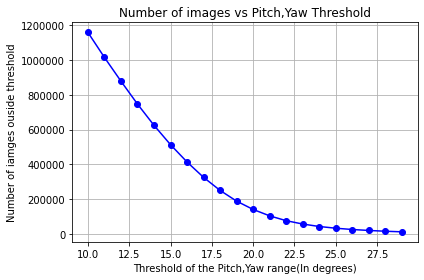

In [61]:
#Plotting the number of images against the number of values outside a given range 

plt.close('all')

fig, ax = plt.subplots(tight_layout=True)

p1,  = ax.plot(threshold_list[0:20], sample_cnt_list[0:20], color='blue', marker='o', label='Number of samples with high error/Total number of samples outside range')

ax.set_title("Number of images vs Pitch,Yaw Threshold")
ax.set_xlabel("Threshold of the Pitch,Yaw range(In degrees)")
ax.set_ylabel("Number of iamges ouside threshold")

ax.ticklabel_format(style='plain')

ax.grid(True)

fig.savefig('/bigpool/fachpraktikum2021/group5/dir_srinivas/STED-gaze/Gaze_Estimation/plots/' + 'N_Images_vs_PitchYaw_threshold.jpg',
            )

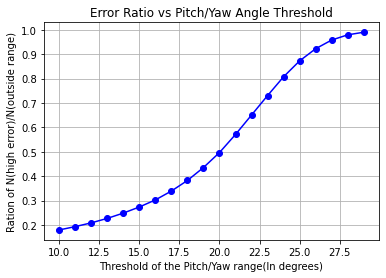

In [68]:

# Plotting the ratio of samples displaying high error vs threshold
# This is done so since we want to find the max threshold beyond which we expereince very high error. 

plt.close('all')

fig, ax = plt.subplots()

p1,  = ax.plot(threshold_list[0:20], error_per_1[0:20], color='blue', marker='o', label='Number of samples with high error/\nTotal number of samples outside range')
#p2,  = plt.plot(threshold_list[0:20], error_per_2[0:20], color='red', marker='o', label='Number of samples with high error/Total number of samples outside range')

#p4,  = plt.plot(threshold_list[0:20], error_per_baseline[0:20], color='black', marker='x', label='Number of samples with high error/Total number of samples outside range')

#ax.set_yticks(np.arange(0, 1, 0.1))


ax.set_title("Error Ratio vs Pitch/Yaw Angle Threshold")
ax.set_xlabel("Threshold of the Pitch/Yaw range(In degrees)")
ax.set_ylabel("Ration of N(high error)/N(outside range)")

#ax.legend(handles=[p1], title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.grid(True)

fig.savefig('/bigpool/fachpraktikum2021/group5/dir_srinivas/STED-gaze/Gaze_Estimation/plots/' + 'Error_Ratio_vs_PitchYaw_threshold.jpg',
            )